Pos Tech - MLET - Tech Challenge - Fase 4

Usar a versão Python 3.10.6 no Kernel

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

[*********************100%%**********************]  1 of 1 completed
c:\Users\lucia\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0136
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 5.9139e-04
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.4608e-04
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.4658e-04
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.9343e-04
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 4.3878e-04
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.4988e-04
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.9729e-04
Epoch 9/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.8618e-04
Epoch 10/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.7445e-04
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


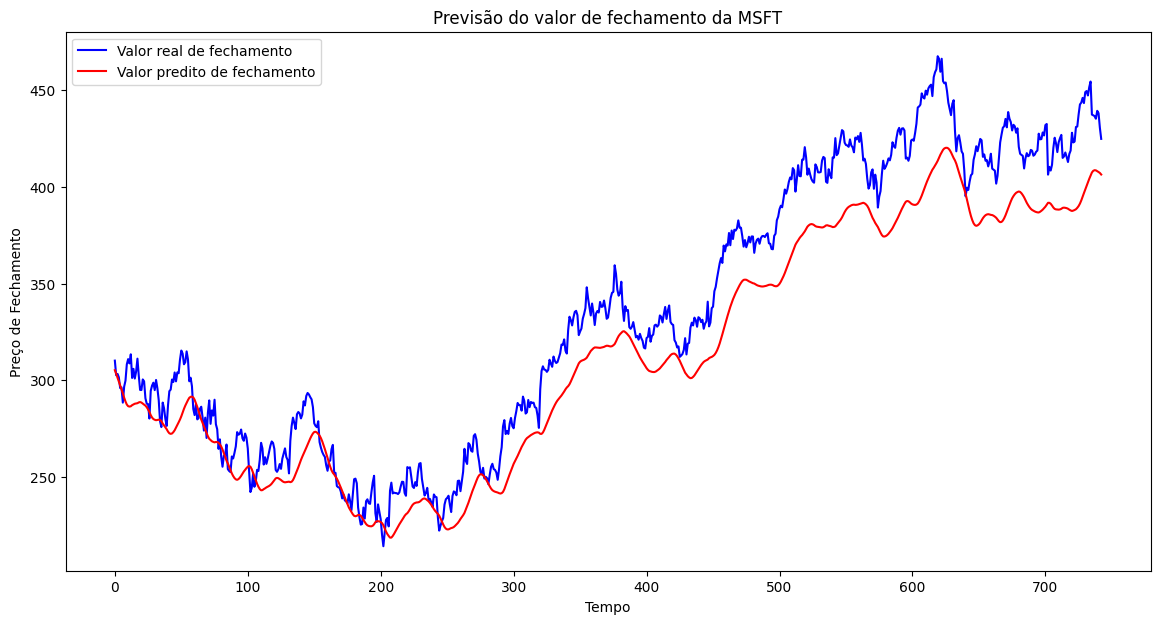

In [2]:
# Baixar os dados históricos da Microsoft (MSFT)
data = yf.download('MSFT', start='2010-01-01', end='2025-01-01')

# Visualizar as primeiras linhas dos dados
data.head()

# Apenas o preço de fechamento
data = data[['Close']]

# Normalizando os dados (escala de 0 a 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Criar conjuntos de dados de treino e teste
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])  # Entradas (últimos 60 dias)
        y.append(data[i + time_step, 0])  # Preço de fechamento
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

# Reshape para LSTM [samples, time_steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Criar o modelo LSTM
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Regularização para evitar overfitting

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))  # Saída de uma única unidade (preço de fechamento)

# Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Fazer previsões
predictions = model.predict(X_test)

# Inverter a normalização dos dados
predictions = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plotar os resultados
plt.figure(figsize=(14, 7))
plt.plot(y_test_rescaled, color='blue', label='Valor real de fechamento')
plt.plot(predictions, color='red', label='Valor predito de fechamento')
plt.title('Previsão do valor de fechamento da MSFT')
plt.xlabel('Tempo')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()
